# PART B: RECURRENT NEURAL NETWORK (50 marks)

## Task
Build a next-word predictor, given a sequence of words. The input to your model is a sequence of words of any length (could be one word, could be five words, etc.). The output of your model is a word that follows that sequence of words. In principle, given an input to your model, you can ask your model to predict the next ten words, by asking your model to predict the next word ten times.

## Submission requirements for Part B
1. Submit a zip file containing all the project files (source code, Jupyter notebook .ipynb file, .html file, and best neural network weights .h5, slides).
2. Submit online via the Assignment link.

## Evaluation criteria:
- **Background research and exploratory data analysis** (10 marks)
- **Feature engineering** (10 marks)
- **Modelling and evaluation** (10 marks)
- **Model improvement** (10 marks)
- **Demo/Presentation and quality of report (Jupyter)** (10 marks)


# Recurrent Neural Network (RNN)

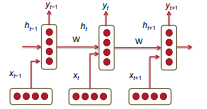

## Overview
A Recurrent Neural Network (RNN) is a type of artificial neural network designed for sequential data processing. Unlike traditional feedforward neural networks, RNNs have connections that form a directed cycle, allowing them to maintain a hidden state that captures information about previous inputs in the sequence.

## Key Concepts
- **Sequential Processing:** RNNs are well-suited for tasks involving sequences, such as time series data, natural language, and speech processing.
- **Hidden State:** RNNs maintain a hidden state that evolves as the network processes each element in the input sequence. This hidden state serves as a memory, allowing the network to capture dependencies and context from past inputs.
- **Vanishing Gradient Problem:** Training RNNs can be challenging due to the vanishing gradient problem, where gradients diminish as they are backpropagated through time, making it difficult for the network to learn long-range dependencies.


## Challenges and Variants
- **Long Short-Term Memory (LSTM):** To address the vanishing gradient problem, LSTM networks, a type of RNN variant, were introduced. LSTMs have gating mechanisms that control the flow of information in and out of the hidden state.
- **Gated Recurrent Unit (GRU):** Another variant similar to LSTM, GRUs have a simplified architecture with fewer parameters, making them computationally more efficient.

In the context of our task, building a next-word predictor, an RNN is employed to capture dependencies and patterns in the sequential data of word sequences, enabling the model to predict the next word in a given sequence.


In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy
import tensorflow as tf 

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, GRU, Attention, LayerNormalization, Concatenate, Input
from tensorflow.keras.models import Model

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import math

warnings.filterwarnings('ignore')

os.environ['PYTHONHASHSEED'] = '1'
keras.utils.set_random_seed(42)
tf.random.set_seed(41)
#generate random weights for reproducibility
np.random.seed(42)
import random
random.seed(42)

# Data Analysis

In [2]:
with open ('train.csv', 'r') as f:
    data = f.read()
    data = data.split('\n')

In [3]:
lines = data
lines = [line for line in lines if line]

# Find the longest sentence based on the number of words
word_counts = [len(line.split()) for line in lines]
longest_sentence_index = word_counts.index(max(word_counts))
longest_sentence = lines[longest_sentence_index]
print(f"Longest Sentence: {longest_sentence}")
print(f"Number of Words in Longest Sentence: {max(word_counts)}\n\n")
most = max(word_counts)

# Find the most robust sentence based on word count
sentences_word_count = [len(sentence.split()) for sentence in lines]
most_robust_sentence_index = sentences_word_count.index(max(sentences_word_count))
most_robust_sentence = lines[most_robust_sentence_index]
print(f"Most Robust Sentence: {most_robust_sentence}")
print(f"Word Count of Most Robust Sentence: {max(sentences_word_count)}\n\n")

# Find the most robust sentence based on character count
sentences_character_count = [len(sentence) for sentence in lines]
most_robust_sentence_index = sentences_character_count.index(max(sentences_character_count))
most_robust_sentence = lines[most_robust_sentence_index]
print(f"Most Robust Sentence: {most_robust_sentence}")
print(f"Character Count of Most Robust Sentence: {max(sentences_character_count)}")


Longest Sentence: "Every act of love is a tribute, a tribute to the boundless power, the boundless power of the heart, to heal and transform, to connect and uplift, to create a legacy of warmth and affection."
Number of Words in Longest Sentence: 35


Most Robust Sentence: "Every act of love is a tribute, a tribute to the boundless power, the boundless power of the heart, to heal and transform, to connect and uplift, to create a legacy of warmth and affection."
Word Count of Most Robust Sentence: 35


Most Robust Sentence: "Every challenge overcome is a testament, a testament to your indomitable spirit, a living proof of your strength and resilience, a reminder that you are capable of conquering any obstacle that comes your way."
Character Count of Most Robust Sentence: 210


# Data Preprocessing

In [4]:
data.remove(data[0])

#remove the " as well as the commas and fullstops

for i in range(len(data)):
    data[i] = data[i].replace('"', '')
    data[i] = data[i].replace(',', '')
    data[i] = data[i].replace('.', '')
    data[i] = data[i].replace(';', '')


In [5]:
data

["Embrace the beauty of every sunrise it's a fresh chance to paint your world with joy",
 'Embrace challenges they are the stepping stones to your greatest victories',
 'Embrace the rhythm of life and let it dance through your soul',
 'Embrace kindness for it has the power to change the world one heart at a time',
 'Embrace the journey for it leads to the destination of your dreams',
 'Embrace your uniqueness for it is the fingerprint of your soul on the universe',
 'Embrace the present moment for it is the only one that truly exists',
 'Embrace your fears for they hold the key to unlocking your true potential',
 'Embrace gratitude and watch how it multiplies the blessings in your life',
 'Embrace the rain for it nourishes the seeds of your future success',
 'Embrace the whispers of your heart they carry the wisdom of the universe',
 'Embrace laughter for it is the music of a joyful heart',
 'Embrace the power of forgiveness for it sets you free from the chains of the past',
 'Embrace 

In [6]:
#split the quotes into a list of words

for i in range(len(data)):
    data[i] = data[i].split(' ')


## Generating more input output pairs

![rolling window](image.png)

We can use the following algorithm to split the data into input and output pairs in the format seen in the image.

In [7]:
#convert quotes into more data friendly format using rolling window

def convert_quotes(data):
    quotes = []
    for quote in data:
        for window_size in range(2, len(quote)):
            for i in range(len(quote)):
                quotes.append(quote[i:i+window_size])
    return quotes


quotes = convert_quotes(data)

In [8]:
#convert quotes into format suitable for tokenization

quotestoken = [' '.join(quote) for quote in quotes]

#tokenize quotes

tokenizer = Tokenizer()
tokenizer.fit_on_texts(quotestoken)
sequences = tokenizer.texts_to_sequences(quotestoken)
total_words = len(tokenizer.word_index) + 1

In [9]:
#now we pad the sequences so that they are all the same length
max_sequence_len = max([len(x) for x in sequences])

padded_sequences = pad_sequences(sequences, maxlen = max_sequence_len, padding = 'pre')

In [10]:
#split the data into X and ywe cacn take the last word as the y and the rest as the X

X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]

#now we need to one hot encode the y values

y = to_categorical(y, num_classes=total_words)

## Modeling

As we are done with the data preprocessing, we can now move on to the modeling part. We will be using the following models:

1. **LSTM** (Long Short Term Memory)
2. **GRU** (Gated Recurrent Unit)
3. **BiLSTM** (Bidirectional LSTM)
4. **BiGRU** (Bidirectional GRU)
5. **Stacked RNN** (Ensemble of different RNN models)



In [17]:
input_len = max_sequence_len - 1

model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))

# Add LSTM layer with 256 units.
model.add(LSTM(256))

# Control overfitting.
model.add(Dropout(0.3))

# Add output layer
model.add(Dense(total_words, activation='softmax'))

KeyboardInterrupt: 

In [160]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=10, verbose=1)

model.summary()

Epoch 1/10
3922/3922 [==============================] - 36s 8ms/step - loss: 4.1070 - accuracy: 0.2376
Epoch 2/10
3922/3922 [==============================] - 30s 8ms/step - loss: 2.4015 - accuracy: 0.4888
Epoch 3/10
3922/3922 [==============================] - 27s 7ms/step - loss: 1.9346 - accuracy: 0.5719
Epoch 4/10
3922/3922 [==============================] - 27s 7ms/step - loss: 1.7140 - accuracy: 0.6112
Epoch 5/10
3922/3922 [==============================] - 27s 7ms/step - loss: 1.5836 - accuracy: 0.6366
Epoch 6/10
3922/3922 [==============================] - 27s 7ms/step - loss: 1.4964 - accuracy: 0.6541
Epoch 7/10
3922/3922 [==============================] - 26s 7ms/step - loss: 1.4384 - accuracy: 0.6641
Epoch 8/10
3922/3922 [==============================] - 27s 7ms/step - loss: 1.3928 - accuracy: 0.6722
Epoch 9/10
3922/3922 [==============================] - 27s 7ms/step - loss: 1.3604 - accuracy: 0.6785
Epoch 10/10
3922/3922 [==============================] - 25s 6ms/step - l

In [161]:
def generate_text(model, tokenizer, max_sequence_len, seed_text, next_words=1): #def next_words for later use
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        predicted_probs = model.predict(token_list)[0]
        predicted_id = np.argmax(predicted_probs)
        
        predicted_word = tokenizer.index_word.get(predicted_id, "")
        seed_text += " " + predicted_word

    return seed_text



In [162]:
#use random seed text from the data

seed_text = 'embrace each day'
                


#generate text

generated_text = generate_text(model, tokenizer, max_sequence_len, seed_text)
print('Predicted Sentence/Quote:', generated_text)

1/1 [==============================] - 0s 286ms/step
Predicted Sentence/Quote: embrace each day with


## Evaluation

Although we can use the model to predict words, we have no way of knowing how good the model is as there are no fixed right or wrong sentences in the English language. So, we will be using the following metrics to evaluate the model instead of basing our evaluation on the accuracy of the model. First thing we can consider is the **perplexity** of the model. Perplexity is a metric that is used to evaluate how well a probability model predicts a sample. 


Perplexity:
It is given by the following formula: 


![perplexity formula](image.png)

Where:
- \(N\) is the total number of words in the dataset.
- \(P(w_i)\) is the probability assigned by the language model to the \(i\)-th word in the dataset.

This is essentially just the exponential of the crossentropy (the loss) of the model. To make the process more efficient, i will apply it only at the end.

In [163]:
#Lets save the first model for comparison with other models later on

RNNdf = pd.DataFrame(columns=['Model Name', 'Generated Text', '"Loss"', '"Accuracy"', 'History'])

# Save the LSTM model information
model_name = 'LSTM'
loss_value = history.history['loss'][-1]
accuracy_value = history.history['accuracy'][-1]

# Create a dictionary with the new values
new_row = {
    'Model Name': model_name,
    'Generated Text': generated_text,
    '"Loss"': loss_value,
    '"Accuracy"': accuracy_value,
    'History': [history]
}

# Concatenate the DataFrames
RNNdf = pd.concat([RNNdf, pd.DataFrame([new_row])], ignore_index=True)

In [164]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(GRU(256))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_gru = model.fit(X, y, epochs=10, verbose=1)

# Generate text
generated_text_gru = generate_text(model, tokenizer, max_sequence_len, seed_text)

# Save GRU model information
model_name_gru = 'GRU'
loss_value_gru = np.min(history_gru.history['loss'])  # Use min loss as an example
accuracy_value_gru = np.max(history_gru.history['accuracy'])  # Use max accuracy as an example
# Append GRU information to the DataFrame
RNNdf = pd.concat([RNNdf, pd.DataFrame([{
    'Model Name': model_name_gru,
    'Generated Text': generated_text_gru,
    '"Loss"': loss_value_gru,
    '"Accuracy"': accuracy_value_gru,
    'History': [history_gru]
}])], ignore_index=True)


Epoch 1/10
3922/3922 [==============================] - 27s 6ms/step - loss: 3.5438 - accuracy: 0.3256
Epoch 2/10
3922/3922 [==============================] - 25s 6ms/step - loss: 2.0248 - accuracy: 0.5615
Epoch 3/10
3922/3922 [==============================] - 25s 6ms/step - loss: 1.6850 - accuracy: 0.6237
Epoch 4/10
3922/3922 [==============================] - 25s 6ms/step - loss: 1.5409 - accuracy: 0.6506
Epoch 5/10
3922/3922 [==============================] - 25s 6ms/step - loss: 1.4593 - accuracy: 0.6653
Epoch 6/10
3922/3922 [==============================] - 25s 6ms/step - loss: 1.4107 - accuracy: 0.6757
Epoch 7/10
3922/3922 [==============================] - 28s 7ms/step - loss: 1.3760 - accuracy: 0.6825
Epoch 8/10
3922/3922 [==============================] - 32s 8ms/step - loss: 1.3478 - accuracy: 0.6869
Epoch 9/10
3922/3922 [==============================] - 32s 8ms/step - loss: 1.3298 - accuracy: 0.6895
Epoch 10/10
1/1 [==============================] - 0s 229ms/step


In [165]:
#Try bidirectional LSTM

model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bidirectional = model.fit(X, y, epochs=10, verbose=1)

# Generate text
generated_text_bidirectional = generate_text(model, tokenizer, max_sequence_len, seed_text)

# Save bidirectional LSTM model information
model_name_bidirectional = 'Bidirectional LSTM'
loss_value_bidirectional = np.min(history_bidirectional.history['loss'])  # Use min loss as an example
accuracy_value_bidirectional = np.max(history_bidirectional.history['accuracy'])  # Use max accuracy as an example

# concat to df
RNNdf = pd.concat([RNNdf, pd.DataFrame([{
    'Model Name': model_name_bidirectional,
    'Generated Text': generated_text_bidirectional,
    '"Loss"': loss_value_bidirectional,
    '"Accuracy"': accuracy_value_bidirectional,
    'History': [history_bidirectional]
}])], ignore_index=True)

Epoch 1/10
3922/3922 [==============================] - 51s 12ms/step - loss: 3.7983 - accuracy: 0.2871
Epoch 2/10
3922/3922 [==============================] - 41s 10ms/step - loss: 2.1577 - accuracy: 0.5377
Epoch 3/10
3922/3922 [==============================] - 43s 11ms/step - loss: 1.7775 - accuracy: 0.6047
Epoch 4/10
3922/3922 [==============================] - 38s 10ms/step - loss: 1.6066 - accuracy: 0.6361
Epoch 5/10
3922/3922 [==============================] - 39s 10ms/step - loss: 1.5122 - accuracy: 0.6530
Epoch 6/10
3922/3922 [==============================] - 39s 10ms/step - loss: 1.4502 - accuracy: 0.6660
Epoch 7/10
3922/3922 [==============================] - 40s 10ms/step - loss: 1.4030 - accuracy: 0.6742
Epoch 8/10
3922/3922 [==============================] - 41s 10ms/step - loss: 1.3712 - accuracy: 0.6797
Epoch 9/10
3922/3922 [==============================] - 40s 10ms/step - loss: 1.3446 - accuracy: 0.6846
Epoch 10/10
1/1 [==============================] - 0s 447ms/step

In [166]:
#Now we can try a bidirectional GRU

model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(Bidirectional(GRU(256)))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bidirectional_gru = model.fit(X, y, epochs=10, verbose=1)

# Generate text
generated_text_bidirectional_gru = generate_text(model, tokenizer, max_sequence_len, seed_text)


# Save bidirectional GRU model information
model_name_bidirectional_gru = 'Bidirectional GRU'
loss_value_bidirectional_gru = np.min(history_bidirectional_gru.history['loss'])  # Use min loss as an example
accuracy_value_bidirectional_gru = np.max(history_bidirectional_gru.history['accuracy'])  # Use max accuracy as an example

# concat to df
RNNdf = pd.concat([RNNdf, pd.DataFrame([{
    'Model Name': model_name_bidirectional_gru,
    'Generated Text': generated_text_bidirectional_gru,
    '"Loss"': loss_value_bidirectional_gru,
    '"Accuracy"': accuracy_value_bidirectional_gru,
    'History': [history_bidirectional_gru]
}])], ignore_index=True)


Epoch 1/10
3922/3922 [==============================] - 40s 10ms/step - loss: 3.5351 - accuracy: 0.3260
Epoch 2/10
3922/3922 [==============================] - 45s 12ms/step - loss: 2.0684 - accuracy: 0.5551
Epoch 3/10
3922/3922 [==============================] - 46s 12ms/step - loss: 1.7271 - accuracy: 0.6164
Epoch 4/10
3922/3922 [==============================] - 46s 12ms/step - loss: 1.5802 - accuracy: 0.6436
Epoch 5/10
3922/3922 [==============================] - 46s 12ms/step - loss: 1.4927 - accuracy: 0.6599
Epoch 6/10
3922/3922 [==============================] - 47s 12ms/step - loss: 1.4347 - accuracy: 0.6717
Epoch 7/10
3922/3922 [==============================] - 47s 12ms/step - loss: 1.3939 - accuracy: 0.6793
Epoch 8/10
3922/3922 [==============================] - 47s 12ms/step - loss: 1.3651 - accuracy: 0.6843
Epoch 9/10
3922/3922 [==============================] - 47s 12ms/step - loss: 1.3421 - accuracy: 0.6877
Epoch 10/10
1/1 [==============================] - 0s 441ms/step

In [167]:
import numpy as np

RNNdf['perplexity'] = RNNdf.apply(lambda row: np.min([np.e**x for x in row['History'][0].history['loss']]), axis=1)


In [168]:
RNNdf

,Model Name,Generated Text,"""Loss""","""Accuracy""",History,perplexity
0,LSTM,embrace each day with,1.333462,0.684291,[<keras.callbacks.History object at 0x000001AD...,3.794157
1,GRU,embrace each day is,1.315856,0.692085,[<keras.callbacks.History object at 0x000001AF...,3.727941
2,Bidirectional LSTM,embrace each day with,1.322789,0.689208,[<keras.callbacks.History object at 0x000001AF...,3.753876
3,Bidirectional GRU,embrace each day with,1.326758,0.692069,[<keras.callbacks.History object at 0x000001AD...,3.768806


## Base Models/Starter Architechture 

From these "Base Models"/Simpler models, we can rougly see that the GRU models perform better compared to the LSTM models by comparing the Perplexity score (lower the better). To further improve the performance of the models, we can consider more complex model, using a different type of input data (with no duplicates) as well as trying adjusting the attention of the model. We can also consider tuning some of the parameters of the models as we have been using basic parameters for the models.

In [169]:
#remove any duplicates

undupequotes = list(set(tuple(quote) for quote in quotes))

In [170]:
#convert quotes into format suitable for tokenization

quotestoken2 = [' '.join(quote) for quote in undupequotes]

#tokenize quotes

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(quotestoken2)
udsequences = tokenizer.texts_to_sequences(quotestoken2)
total_wordsud = len(tokenizer2.word_index) + 1

In [171]:
#now we pad the sequences so that they are all the same length
max_sequence_lenud = max([len(x) for x in udsequences])

padded_sequencesud = pad_sequences(udsequences, maxlen = max_sequence_lenud, padding = 'pre')

input_lenud = max_sequence_lenud - 1

In [172]:
#split the data into X and ywe cacn take the last word as the y and the rest as the X

Xud = padded_sequences[:, :-1]
yud = padded_sequences[:, -1]

#now we need to one hot encode the y values

yud = to_categorical(yud, num_classes=total_wordsud)

In [173]:
# We now have 2 datasets, one with duplicates and one without

# We can now write a function that receives a model, compiles it and fits it onto the two datasets
def fit_model(model, X, y, model_name, RNNdf, tokenizer, max_sequence_len, epochs=10, seed_text=''):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model with duplicates
    history = model.fit(X, y, epochs= epochs, verbose=0)
    generated_text = generate_text(model, tokenizer, max_sequence_len, seed_text)
    generated_text = seed_text + ' ' + generated_text
    RNNdf = pd.concat([RNNdf, pd.DataFrame([{
        'Model Name': model_name + '',
        'Generated Text': generated_text,
        '"Loss"': np.min(history.history['loss']),
        '"Accuracy"': np.max(history.history['accuracy']),
        'History': [history]
    }])], ignore_index=True)

    return RNNdf


In [174]:
# construct a stacked GRU model
model = Sequential()
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(Bidirectional(GRU(256)))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))

RNNdf = fit_model(model, X, y, 'Stacked BidiGRU (with duplicates)', RNNdf, tokenizer, max_sequence_len, epochs=10, seed_text=seed_text)

model.summary()

1/1 [==============================] - 1s 829ms/step
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 33, 10)            11990     
                                                                 
 bidirectional_29 (Bidirecti  (None, 33, 512)          411648    
 onal)                                                           
                                                                 
 bidirectional_30 (Bidirecti  (None, 512)              1182720   
 onal)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 1199)              615087    
                                                                 


In [175]:
model = Sequential()
model.add(Embedding(total_wordsud, 10, input_length=input_lenud))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(Bidirectional(GRU(256)))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))

RNNdf = fit_model(model, X, y, 'Stacked BidiGRU (without duplicates)', RNNdf, tokenizer2, max_sequence_lenud, epochs=10, seed_text=seed_text)

model.summary()

1/1 [==============================] - 1s 789ms/step
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 33, 10)            11990     
                                                                 
 bidirectional_31 (Bidirecti  (None, 33, 512)          411648    
 onal)                                                           
                                                                 
 bidirectional_32 (Bidirecti  (None, 512)              1182720   
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 1199)              615087    
                                                                 


In [176]:
RNNdf

,Model Name,Generated Text,"""Loss""","""Accuracy""",History,perplexity
0,LSTM,embrace each day with,1.333462,0.684291,[<keras.callbacks.History object at 0x000001AD...,3.794157
1,GRU,embrace each day is,1.315856,0.692085,[<keras.callbacks.History object at 0x000001AF...,3.727941
2,Bidirectional LSTM,embrace each day with,1.322789,0.689208,[<keras.callbacks.History object at 0x000001AF...,3.753876
3,Bidirectional GRU,embrace each day with,1.326758,0.692069,[<keras.callbacks.History object at 0x000001AD...,3.768806
4,Stacked BidiGRU (with duplicates),embrace each day embrace each day with,1.316724,0.694898,[<keras.callbacks.History object at 0x000001B1...,NaN
5,Stacked BidiGRU (without duplicates),embrace each day embrace each day liberation,1.313115,0.695719,[<keras.callbacks.History object at 0x000001B1...,NaN


## Evaluation

We can see that the stacked GRU model performs the best out of all the models. This is because the stacked GRU model is able to learn more complex patterns in the data compared to the other models. We can try to further increase the performance of the model by adding an attention layer to the model. An attention layer is a layer that is added to the model to help the model focus on the important parts of the input data. This will help the model to learn more complex patterns in the data and thus, increase the performance of the model. As previously mentioned, we can also try to tune the parameters of the model to further increase the performance of the model, we will be using a width of 64 for the first layer and a width of 512 for the second layer. 

In [177]:
input = Input(shape=(input_len,))
x = Embedding(total_words, 10, input_length=input_len)(input)
att_in = Bidirectional(GRU(64, return_sequences=True))(x)  # Set return_sequences=True to get the full sequence for attention
att_out = Attention(name='attention_weighted_average')([att_in, att_in])
x = Concatenate()([att_out, x])
x = GRU(512)(x)
x = Dense(total_words, activation='softmax')(x)
AttentionGRUModel = Model(input, x)

RNNdf = fit_model(AttentionGRUModel, X, y, 'StackedBIdiGru with Attention (with duplicates)', RNNdf, tokenizer, max_sequence_len, seed_text=seed_text)

model.summary()

1/1 [==============================] - 1s 838ms/step
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 33, 10)            11990     
                                                                 
 bidirectional_31 (Bidirecti  (None, 33, 512)          411648    
 onal)                                                           
                                                                 
 bidirectional_32 (Bidirecti  (None, 512)              1182720   
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 1199)              615087    
                                                                 


In [178]:
input = Input(shape=(input_len,))
x = Embedding(total_words, 10, input_length=input_len)(input)
att_in = Bidirectional(GRU(64, return_sequences=True))(x)  # Set return_sequences=True to get the full sequence for attention
att_out = Attention(name='attention_weighted_average')([att_in, att_in])
x = Concatenate()([att_out, x])
x = GRU(512)(x)
x = Dense(total_words, activation='softmax')(x)
AttentionGRUModel = Model(input, x)

RNNdf = fit_model(AttentionGRUModel, Xud, yud, 'StackedBIdiGru with Attention (without duplicates)', RNNdf, tokenizer2, max_sequence_lenud, seed_text=seed_text)

model.summary()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
RNNdf['perplexity'] = RNNdf.apply(lambda row: np.min([np.e**x for x in row['History'][0].history['loss']]), axis=1)

RNNdf

,Model Name,Generated Text,"""Loss""","""Accuracy""",History,perplexity
0,LSTM,embrace each day is,1.322891,0.686124,[<keras.callbacks.History object at 0x000001AD...,3.754261
1,GRU,embrace each day is,1.315018,0.692922,[<keras.callbacks.History object at 0x000001AD...,3.724817
2,Bidirectional LSTM,embrace each day is,1.320789,0.689599,[<keras.callbacks.History object at 0x000001AD...,3.746376
3,Bidirectional GRU,embrace each day with,1.309555,0.695305,[<keras.callbacks.History object at 0x000001B0...,3.704524
4,Stacked BidiGRU (with duplicates),embrace each day embrace each day is,1.315550,0.695289,[<keras.callbacks.History object at 0x000001AD...,3.726800
5,Stacked BidiGRU (without duplicates),embrace each day embrace each day clarity,1.325368,0.693902,[<keras.callbacks.History object at 0x000001B1...,3.763570
6,StackedBIdiGru with Attention (without duplica...,embrace each day embrace each day is,1.234271,0.709619,[<keras.callbacks.History object at 0x000001B1...,3.435874
7,StackedBIdiGru without Attention (without dupl...,embrace each day embrace each day through,1.246347,0.709993,[<keras.callbacks.History object at 0x000001B1...,3.477617


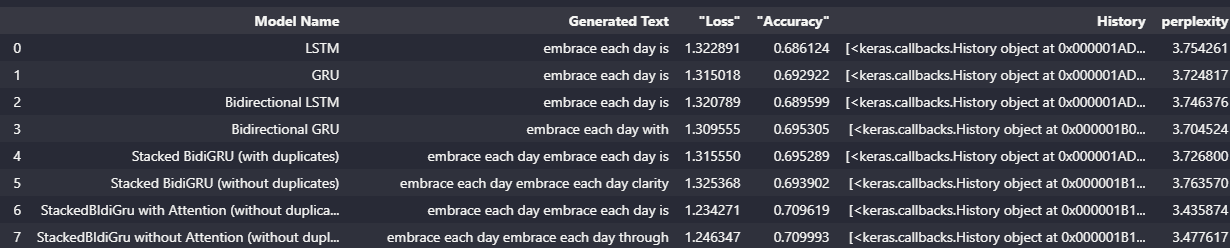

# Evaluation

We can see that the Attention layer has allowed the model to improve to a decent benchmark; however, there are some problems that we have to address first.

1. **Slow Training Time:**
   - To improve the speed of the model, consider increasing the batch size to make full use of the parallelism of the GPU.

2. **Interpretability:**
   - Currently, we are unable to interpret the performance of the model as there is no way to look at the training progress. To address this, we can write a function that will plot out the training progress of the model.

3. **Parameter Tuning:**
   - Most of the parameters are still at their default values. Consider tuning certain parameters to further improve the performance of the model. This could include:
      - The embedding size
      - The width of the layers
      - Learning rate

4. **Making Predictions:**
   - As the models have reached a decent performance, it's time to make proper predictions using the seed texts from the assignment brief. You can use the trained models to generate text and assess the quality of the generated sequences.




In [13]:
def plot_training_progress(history):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    axes[0].plot(history.history['loss'])
    axes[0].set_title('Model loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')

    axes[1].plot(history.history['accuracy'])
    axes[1].set_title('Model accuracy')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_xlabel('Epoch')

    axes[2].plot([np.e**x for x in history.history['loss']])
    axes[2].set_title('Model perplexity')
    axes[2].set_ylabel('Perplexity')
    axes[2].set_xlabel('Epoch')

    plt.tight_layout()

    plt.show()


In [23]:
#rewrite the fitting function to increase the batch size, as well as to recursively generate text 10 times
def generate_text_recursive(seed_text, tokenizer, max_sequence_len, model):
    generated_text = seed_text
    for _ in range(10):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        predicted_probs = model.predict(token_list, verbose = 0)[0]
        predicted_id = np.random.choice(len(predicted_probs), p=predicted_probs)

        predicted_word = tokenizer.index_word.get(predicted_id, "")
        seed_text += " " + predicted_word

    return seed_text

def fit_model(model, X, y, model_name, RNNdf, tokenizer, max_sequence_len, epochs=10, seed_text=['']):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model with duplicates
    history = model.fit(X, y, epochs= epochs, verbose=1, batch_size=1000)
    text_list = []
    for text in seed_text:
        generated_text = generate_text_recursive(text, tokenizer, max_sequence_len, model)
        print(generated_text)
        text_list.append(generated_text)

    RNNdf = pd.concat([RNNdf, pd.DataFrame([{
        'Model Name': model_name + '',
        'Generated Text': text_list,
        '"Loss"': np.min(history.history['loss']),
        '"Accuracy"': np.max(history.history['accuracy']),
        'History': [history]
    }])], ignore_index=True)

    plot_training_progress(history)

    return RNNdf


In [15]:
seed_text_list = ['embrace each day',
                'radiate some',
                'believe that',
                "life's actual purpose is",
                'dance through each and every',
                'let your time and energy',
                'every person is',
                'our country Singapore is',
                'planet earth is',
                'morning and evening would make it']

Epoch 1/100
126/126 [==============================] - 10s 55ms/step - loss: 4.9003 - accuracy: 0.1569
Epoch 2/100
126/126 [==============================] - 7s 55ms/step - loss: 2.6700 - accuracy: 0.4625
Epoch 3/100
126/126 [==============================] - 7s 55ms/step - loss: 1.8983 - accuracy: 0.5864
Epoch 4/100
126/126 [==============================] - 7s 54ms/step - loss: 1.5647 - accuracy: 0.6451
Epoch 5/100
126/126 [==============================] - 7s 54ms/step - loss: 1.3939 - accuracy: 0.6751
Epoch 6/100
126/126 [==============================] - 7s 55ms/step - loss: 1.2964 - accuracy: 0.6924
Epoch 7/100
126/126 [==============================] - 7s 55ms/step - loss: 1.2395 - accuracy: 0.7022
Epoch 8/100
126/126 [==============================] - 7s 55ms/step - loss: 1.1987 - accuracy: 0.7094
Epoch 9/100
126/126 [==============================] - 7s 55ms/step - loss: 1.1729 - accuracy: 0.7122
Epoch 10/100
126/126 [==============================] - 7s 55ms/step - loss: 1.15

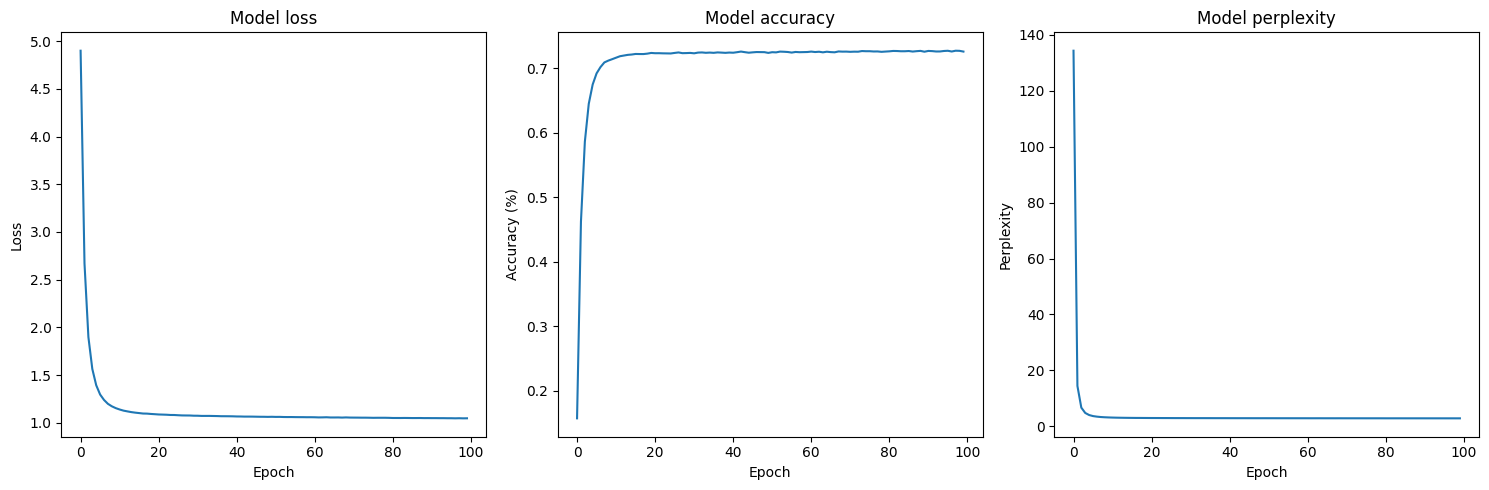

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 33, 256)      306944      ['input_4[0][0]']                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 33, 128)     123648      ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 attention_weighted_average (At  (None, 33, 128)     0           ['bidirectional_3[0][0]',  

In [24]:
#The models using the dataset with duplicates seem to work the best so we will use that dataset for the rest of the models
# We can now try to increase the embedding layer size as well as the epochs

input = Input(shape=(input_len,))
x = Embedding(total_words, 256, input_length=input_len)(input)
att_in = Bidirectional(GRU(64, return_sequences=True))(x) 
att_out = Attention(name='attention_weighted_average')([att_in, att_in])
x = Concatenate()([att_out, x])
x = GRU(512)(x)
x = Dense(total_words, activation='softmax')(x)
AttentionGRUModelplus = Model(input, x)

RNNdf = fit_model(AttentionGRUModelplus, X, y, 'StackedBIdiGru with Attention (with duplicates)++', RNNdf, tokenizer, max_sequence_len,epochs = 100, seed_text=seed_text_list)

AttentionGRUModelplus.summary()

In [28]:
RNNdf[:1]['Generated Text'][0]

['embrace each day with a heart full of gratitude and watch how it',
 'radiate some love for it is the truest expression of your being',
 'believe that innovation knows no bounds your purpose and passion ignites change',
 "life's actual purpose is a step a step towards witnessing witnessing miracles the extraordinary",
 'dance through each and every step towards the tranquility the tranquility of the heart a',
 'let your time and energy will conspire in your favor you to moments of happiness',
 'every person is boundless power to the new day full of possibilities it',
 'our country Singapore is illuminated by the light of our inner wisdom of the',
 'planet earth is preserved with pride and kindness that resonates with the world',
 'morning and evening would make it is the essence of true beauty and beauty of our']

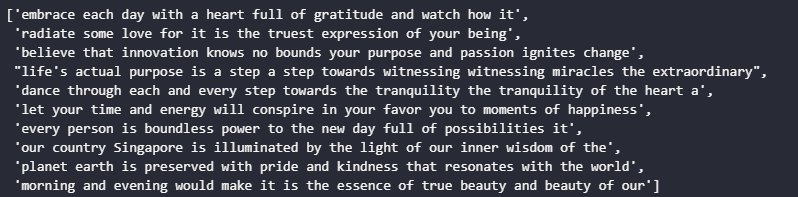

From these example outputs, we can rougly see that the model is able to generate some coherent sentences. For example: 'radiate some love for it is the truest expression of your being'. As well as some incomplete sentences that could make sense once fully formed, for example: 'embrace each day with a heart full of gratitude and watch how it'


Overall, we are limited by the size of the dataset, as well as certain limitations from the assignment, we are unable to train the models to an excellent performance. Due to the nature of the assignment, i will also not be training the RNN model to recognise sentence structures, as we are only required to predict the next word in a sequence, as such we will have to deal with incomplete senteces. 


As a final way to improve our model, we can try to implement lr decay to the model. This will allow the model to learn more efficiently as the learning rate will decrease as the model trains.

In [31]:
from keras.callbacks import ReduceLROnPlateau

input = Input(shape=(input_len,))
x = Embedding(total_words, 256, input_length=input_len)(input)
att_in = Bidirectional(GRU(64, return_sequences=True))(x) 
att_out = Attention(name='attention_weighted_average')([att_in, att_in])
x = Concatenate()([att_out, x])
x = GRU(512)(x)
x = Dense(total_words, activation='softmax')(x)
AttentionGRUModelplus = Model(input, x)


AttentionGRUModelplus.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = AttentionGRUModelplus.fit(X, y, epochs= 100, verbose=1, batch_size=1000, callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)])

Epoch 1/100
126/126 [==============================] - 12s 61ms/step - loss: 4.9425 - accuracy: 0.1482
Epoch 2/100
126/126 [==============================] - 8s 60ms/step - loss: 2.4943 - accuracy: 0.4906
Epoch 3/100
126/126 [==============================] - 8s 60ms/step - loss: 1.6482 - accuracy: 0.6357
Epoch 4/100
126/126 [==============================] - 8s 60ms/step - loss: 1.3744 - accuracy: 0.6827
Epoch 5/100
126/126 [==============================] - 7s 58ms/step - loss: 1.2611 - accuracy: 0.7002
Epoch 6/100
126/126 [==============================] - 8s 66ms/step - loss: 1.2012 - accuracy: 0.7093
Epoch 7/100
126/126 [==============================] - 8s 67ms/step - loss: 1.1658 - accuracy: 0.7152
Epoch 8/100
126/126 [==============================] - 8s 66ms/step - loss: 1.1445 - accuracy: 0.7181
Epoch 9/100
126/126 [==============================] - 8s 66ms/step - loss: 1.1313 - accuracy: 0.7184
Epoch 10/100
126/126 [==============================] - 8s 66ms/step - loss: 1.12

NameError: name 'seed_text' is not defined

embrace each day is a gift a reminder of the miracle of life
radiate some resilience and let it be the fortress of your spirit
believe that fills the air with joy and lightheartedness mind and soul
life's actual purpose is a reminder of the earth's fiery core success and uplifts
dance through each and every reign is a canvas for new beginnings and fresh opportunities
let your time and energy it radiates from your heart to the world of possibilities
every person is a chapter in your story write it with love and
our country Singapore is rich and vibrant experiences and fostering understanding and compassion that
planet earth is a canvas paint it with vibrant experiences and choices we
morning and evening would make it is a chance for adventure for it is the heartbeat


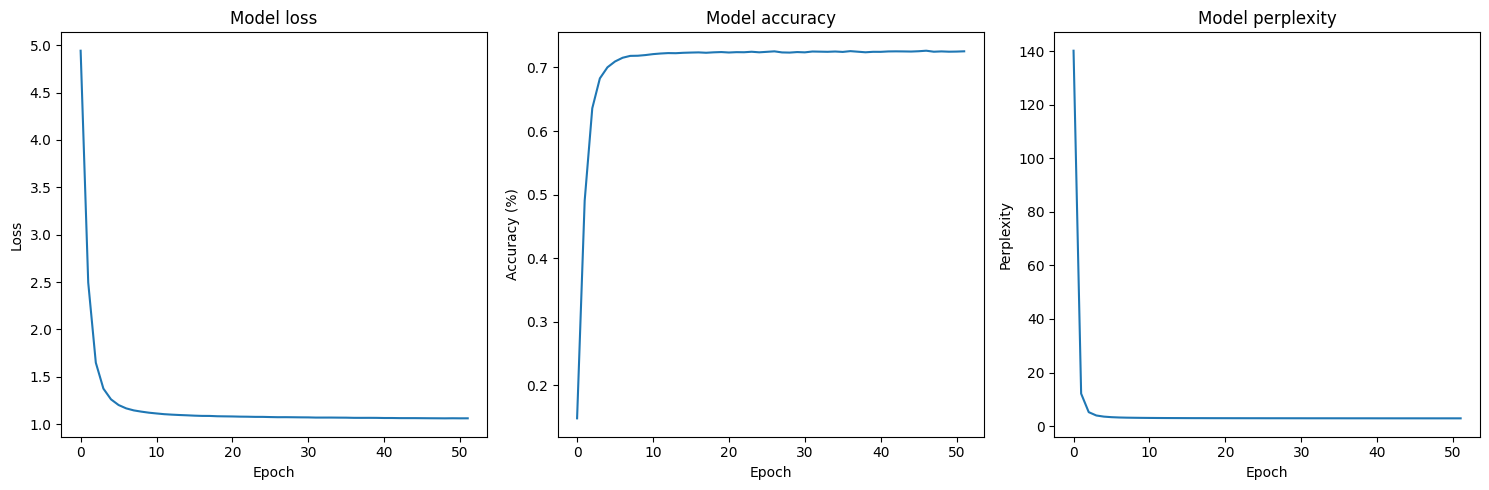

In [32]:
text_list = []
for text in seed_text_list:
    generated_text = generate_text_recursive(text, tokenizer, max_sequence_len, AttentionGRUModelplus)
    print(generated_text)
    text_list.append(generated_text)

RNNdf = pd.concat([RNNdf, pd.DataFrame([{
    'Model Name': 'AttentionGRUModelplus with lrd',
    'Generated Text': text_list,
    '"Loss"': np.min(history.history['loss']),
    '"Accuracy"': np.max(history.history['accuracy']),
    'History': [history]
}])], ignore_index=True)

plot_training_progress(history)

In [33]:
RNNdf

,Model Name,Generated Text,"""Loss""","""Accuracy""",History
0,StackedBIdiGru with Attention (with duplicates)++,[embrace each day with a heart full of gratitu...,1.046573,0.727591,[<keras.callbacks.History object at 0x0000020B...
1,AttentionGRUModelplus with lrd,[embrace each day is a gift a reminder of the ...,1.060509,0.726252,[<keras.callbacks.History object at 0x0000020B...
